In [3]:
import os
import sys
sys.path.insert(0,'/home/junwoony/Desktop/DOGSS/')

import numpy as np
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
%env CUDA_LAUNCH_BLOCKING=1

import mongo
import time
import pickle
import random
import numpy as np
import tqdm
import copy
import matplotlib.pyplot as plt
import multiprocess as mp

from pymatgen.io.ase import AseAtomsAdaptor

import torch
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from torch.optim.lbfgs import LBFGS


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.metrics import get_scorer
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, LoadInitState #needs skorch 0.4.0, conda-forge version at 0.3.0 doesn't cut it
import skorch.callbacks.base
from skorch.dataset import CVSplit
from skorch.callbacks.lr_scheduler import WarmRestartLR, LRScheduler

from utils.adamwr.adamw import AdamW
from utils.adamwr.cosine_scheduler import CosineLRWithRestarts


from sigopt_sklearn.search import SigOptSearchCV
import seaborn as sns


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
env: CUDA_LAUNCH_BLOCKING=1


In [5]:
# SDT_list = pickle.load(open('../../../cgcnn/bond_regression3/new2/SDT_list.pkl', 'rb'))
docs = pickle.load(open('../../inputs/surfaces/final_docs.pkl', 'rb'))
docs_test_surface = pickle.load(open('./new_backup/docs_test_surface.pkl', 'rb'))
docs_test_slab = pickle.load(open('./new_backup/docs_test_slab.pkl', 'rb'))
docs_test = pickle.load(open('./new_backup/docs_test.pkl', 'rb'))

# structures = SDT_list[0]
# orig_atom_fea_len = structures[0].shape[-1]
# nbr_fea_len = structures[1].shape[-1]

# docs_test = pickle.load(open('./new_backup/docs_test.pkl','rb'))

# target_list = np.array([sdt[-1][sdt[9]].numpy() for sdt in SDT_list]).reshape(-1,1) #get final_pos of free atoms ONLY

In [6]:
len(docs_test)

601

In [27]:
# SDT_training, SDT_test, target_training, target_test, docs_training, docs_test \
# = train_test_split(SDT_list, target_list, docs, test_size=0.1, random_state=42)

In [5]:
# natoms =[]
# types = []
# steps = []
# distances = []
# filtered_idx = []
# docs_test_new = []
# docs_test_surface, docs_test_slab = [], []
# for doc in docs_test:
#     natoms.append(doc['atoms']['natoms'])
#     types.extend(doc['atoms']['chemical_symbols'])
#     atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
#     atoms_final = mongo.make_atoms_from_doc(doc, is_initial=False)
#     if atoms.constraints:
#         fixed_atom_idx = atoms.constraints[0].index
#         base = np.ones(len(atoms.positions))
#         base[fixed_atom_idx] = 0
#         free_atom_idx = np.where(base==1)[0]
        
#     else:
#         free_atom_idx = np.arange(len(atoms))
#     difference = atoms.positions[free_atom_idx] - atoms_final.positions[free_atom_idx]
#     dist = np.sqrt(np.sum(difference**2, axis=1))
#     if np.mean(dist) > 0.06:
# #         distances.append(dist)
# #         filtered_idx.append(doc['idx'])
#         docs_test_new.append(doc['idx'])
#         if doc['data'] == 'surface':
#             docs_test_surface.append(doc['idx'])
#         elif doc['data'] == 'slab':
#             docs_test_slab.append(doc['idx'])


In [7]:
import ase
from ase.io import read, write
import glob


steps_initial, steps_test = [], []
E_initial, E_pred = [], []
E_pred_final, E_init_final = [], []
dist_changes_initial, dist_changes_final = [], []
F_initial, F_pred = [], []
F_pred_final, F_init_final = [], []

test_final, initial_final =[], []
test_initial, initial_initial= [], []
dist_init, dist_test = [], []
i=0
total_atoms = 0
filtered=0


for d in range(2):
    if d == 0:
        docs_idx = docs_test_surface
    elif d == 1:
        docs_idx = docs_test_slab
        
    for idx in tqdm.tqdm(docs_idx):
        have_results = False
        if d == 0:
            geom_initial = read('./new_backup/traj_surface/results_initial/%d_initial_vasprun.xml' %idx, index=':', format='vasp-xml')
            geom_test = read('./new_backup/traj_surface/results_test/%d_test_vasprun.xml' %idx, index=':', format='vasp-xml')
            have_results = True
        elif d == 1:
            if idx in initial_results:
                have_results = True
                geom_initial = read('./new_backup/traj_slab/results_initial/%d_initial_vasprun.xml' %idx, index=':', format='vasp-xml')
                geom_test = read('./new_backup/traj_slab/results_test/%d_test_vasprun.xml' %idx, index=':', format='vasp-xml')
    
        

        if have_results:

            c_initial, c_test = 0, 0
            force_initial, force_test = 10, 10

            ### Set max_force < 0.05 as a convergence rule ###
            while force_initial > 0.05:
                atom = geom_initial[c_initial]
                force_initial = np.max(np.abs(atom.get_forces()))
                c_initial += 1

            while force_test > 0.05:
                atom = geom_test[c_test]
                force_test = np.max(np.abs(atom.get_forces()))
                c_test += 1

            ### To ensure the convergence to the same local minima < dE = 0.2 ###
            if np.abs(geom_initial[c_initial-1].get_potential_energy() - geom_test[c_test-1].get_potential_energy()) < 2:
                steps_initial.append(c_initial)
                steps_test.append(c_test)


                atoms_initial = geom_initial[0]
                atoms_test = geom_test[0]

                if atoms_initial.constraints:
                    fixed_atom_idx = atoms_initial.constraints[0].index
                    base = np.ones(len(atoms_initial.positions))
                    base[fixed_atom_idx] = 0
                    free_atom_idx = np.where(base==1)[0]

                else:
                    free_atom_idx = np.arange(len(atoms_initial))

                difference_test = geom_test[0].positions[free_atom_idx] - geom_test[-1].positions[free_atom_idx]


                test_final.append(geom_test[c_test-1].get_scaled_positions()[free_atom_idx])
                initial_final.append(geom_initial[c_initial-1].get_scaled_positions()[free_atom_idx])
                test_initial.append(geom_test[0].get_scaled_positions()[free_atom_idx])
                initial_initial.append(geom_test[0].get_scaled_positions()[free_atom_idx])

                difference = geom_initial[0].positions[free_atom_idx] - geom_test[0].positions[free_atom_idx]
                dist = np.sqrt(np.sum(difference**2, axis=1))
                dist_changes_initial.append(np.mean(dist))


                difference_f = geom_initial[c_initial-1].positions[free_atom_idx] - geom_test[c_test-1].positions[free_atom_idx]
                dist_f = np.sqrt(np.sum(difference_f**2, axis=1))
                dist_changes_final.append(np.mean(dist_f))



                difference_init = geom_initial[0].positions[free_atom_idx] - geom_initial[c_initial-1].positions[free_atom_idx]
                dist_init.append(np.mean(np.sqrt(np.sum(difference_init**2, axis=1))))

                difference_test = geom_test[0].positions[free_atom_idx] - geom_test[c_test-1].positions[free_atom_idx]
                dist_test.append(np.mean(np.sqrt(np.sum(difference_test**2, axis=1))))



        #         if c_initial - c_test == -58:
        #             energies_initial, forces_initial = [],[]
        #             energies_test, forces_test = [], []

        #             for gm in geom_initial:
        #                 energy = gm.get_potential_energy()
        #                 force = np.max(gm.get_forces())
        #                 energies_initial.append(energy)
        #                 forces_initial.append(force)
        #             for gm in geom_test:
        #                 energy = gm.get_potential_energy()
        #                 force = np.max(gm.get_forces())
        #                 energies_test.append(energy)
        #                 forces_test.append(force)

        #             print(np.max(np.abs(geom_initial[c_initial-1].get_forces())), np.max(np.abs(geom_test[c_test-1].get_forces())))
        #             print(geom_initial[-1].get_potential_energy() - geom_test[-1].get_potential_energy())
        #             print(geom_initial[c_initial-1].get_potential_energy() - geom_test[c_test-1].get_potential_energy())


                E_initial.append(geom_initial[0].get_potential_energy())
                E_pred.append(geom_test[0].get_potential_energy())
                E_init_final.append(geom_initial[c_initial-1].get_potential_energy())
                E_pred_final.append(geom_test[c_test-1].get_potential_energy())


                F_initial.append(np.max(np.abs(geom_initial[0].get_forces())))
                F_pred.append(np.max(np.abs(geom_test[0].get_forces())))
                F_pred_final.append(np.max(np.abs(geom_test[c_test-1].get_forces())))
                F_init_final.append(np.max(np.abs(geom_initial[c_initial-1].get_forces())))

                i +=1


            else:
                print('Energy difference:', np.abs(geom_initial[c_initial-1].get_potential_energy() - geom_test[c_test-1].get_potential_energy()))
                filtered+=1
        
# ##### IF we use F < 0.03,
#         steps_initial.append(len(geom_initial))
#         steps_test.append(len(geom_test))
        
            
steps_initial, steps_test = np.array(steps_initial), np.array(steps_test)
E_initial, E_pred, E_init_final, E_pred_final = np.array(E_initial), np.array(E_pred), np.array(E_init_final), np.array(E_pred_final)
dist_init, dist_test = np.array(dist_init), np.array(dist_test)
F_initial, F_pred = np.array(F_initial), np.array(F_pred)
F_init_final, F_pred_final = np.array(F_init_final), np.array(F_pred_final)

test_final = np.concatenate(test_final)
initial_final = np.concatenate(initial_final)
test_initial = np.concatenate(test_initial)
initial_initial = np.concatenate(initial_initial)



print('# of diferent local minima', filtered)
# write('trajectory.traj', geom, format='traj')

 70%|███████   | 147/209 [00:10<00:04, 13.51it/s]

Energy difference: 2.0915085400000066


  0%|          | 0/392 [00:00<?, ?it/s]


NameError: name 'initial_results' is not defined

In [40]:
print('Avg reduction',1 - np.sum(steps_test)/np.sum(steps_initial))
print(np.mean(steps_initial), np.mean(steps_test), np.mean(steps_initial)- np.mean(steps_test))
diff = steps_initial - steps_test
print('% of worse cases:', len(np.where(diff < 0)[0])/len(steps_initial))
bad_idx = np.where(diff < 0)[0]
base = np.ones_like(steps_initial)
base[bad_idx] = 0
good_idx = np.where(base == 1)[0]
print(bad_idx)
print(diff[bad_idx])
print('bad_results:', np.mean(diff[bad_idx]))
diff_E = np.abs(E_initial - E_pred)
print('mean of relaxed energy difference:', np.mean(diff_E))
print('Energy difference for bad_idx',diff_E[bad_idx])
print('Forces:', np.mean(F_initial), np.mean(F_pred), np.mean(F_pred)/np.mean(F_initial))

Avg reduction 0.27932489451476794
15.323275862068966 11.043103448275861 4.280172413793105
% of worse cases: 0.12931034482758622
[  0   2  12  21  31  34  38  44  46  47  77  81  87  91  94 114 116 137
 144 159 163 170 183 186 192 200 210 220 227 228]
[ -2  -5 -15 -11  -5  -3  -6  -1  -4  -2  -2  -4  -2  -1  -8  -5  -5  -1
 -58  -8  -1  -6  -1  -1  -2  -5  -9  -2  -2  -6]
bad_results: -6.1
mean of relaxed energy difference: 0.6401522951293108
Energy difference for bad_idx [0.19068601 0.08343602 1.15943672 0.39830491 0.24515548 0.68949334
 0.01164478 0.67183062 0.21723267 0.16994638 0.57181495 0.18146079
 0.45853306 0.37851263 0.59972503 0.01167316 0.46525162 0.16562411
 0.20895326 0.18671761 1.02637831 0.10052273 0.6389322  0.27742461
 0.52522472 0.15452978 0.03331558 0.38557623 0.18776054 0.18448558]
Forces: 1.318458600775862 0.4743112660775862 0.3597468026667446


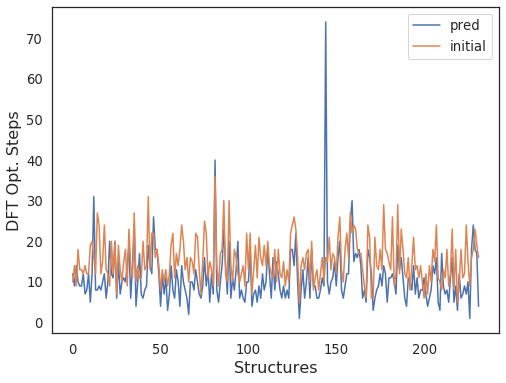

In [30]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(8, 6)})
sns.set(font_scale = 1.2)
# sns.set_style("whitegrid")
sns.set_style("white")

# c = list(zip(steps_test, steps_initial))

# random.seed(10)#3,10
# random.shuffle(c)

# a,b = zip(*c)

plt.plot(steps_test, label='pred')
plt.plot(steps_initial, label='initial')
plt.legend(loc='upper right')
plt.ylabel('DFT Opt. Steps', fontsize=16)
plt.xlabel('Structures', fontsize=16)
# plt.savefig('./new_backup/steps_after.pdf')
# plt.savefig('./new_backup/steps_before.pdf')

plt.show()

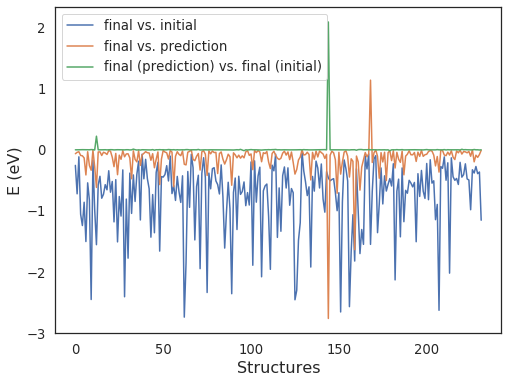

In [31]:
plt.plot((E_init_final - E_initial), label='final vs. initial')
plt.plot((E_pred_final - E_pred), label='final vs. prediction')
plt.plot((E_init_final - E_pred_final), label='final (prediction) vs. final (initial)')
plt.legend(loc='upper left')
plt.ylabel('E (eV)', fontsize=16)
plt.xlabel('Structures', fontsize=16)
plt.savefig('./new_backup/E_before.pdf')
# plt.savefig('./new_backup/E_after.pdf')

plt.show()

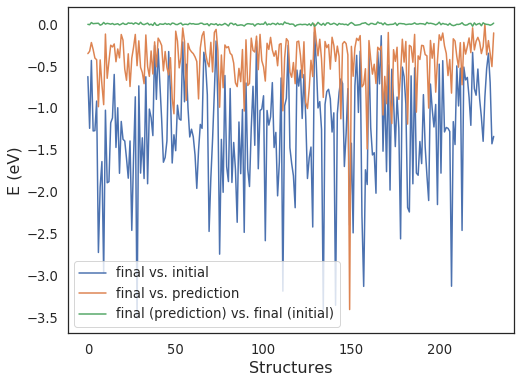

In [41]:
plt.plot((F_init_final - F_initial), label='final vs. initial')
plt.plot((F_pred_final - F_pred), label='final vs. prediction')
plt.plot((F_init_final - F_pred_final), label='final (prediction) vs. final (initial)')
plt.legend(loc='lower left')
plt.ylabel('E (eV)', fontsize=16)
plt.xlabel('Structures', fontsize=16)
plt.savefig('./new_backup/F_before.pdf')
# plt.savefig('./new_backup/E_after.pdf')

plt.show()

In [10]:
idx = docs_test_surface[3]
geom_initial = read('./new_backup/traj_surface/results_initial/%d_initial_vasprun.xml' %idx, index=':', format='vasp-xml')
geom_test = read('./new_backup/traj_surface/results_test/%d_test_vasprun.xml' %idx, index=':', format='vasp-xml')

c_initial, c_test = 0, 0
force_initial, force_test = 10, 10

### Set max_force < 0.05 as a convergence rule ###
while force_initial > 0.05:
    atom = geom_initial[c_initial]
    force_initial = np.max(np.abs(atom.get_forces()))
    c_initial += 1

while force_test > 0.05:
    atom = geom_test[c_test]
    force_test = np.max(np.abs(atom.get_forces()))
    c_test += 1
    
geom_initial[0].write('./new_backup/$d_0init.traj'%idx)
geom_test[0].write('./new_backup/$d_1ped.traj'%idx)
geom_test[c_test-1].write('./new_backup/d_2pred_final.traj'%idx)
geom_test[c_initial-1].write('./new_backup/$d_3init_final.traj'%idx)


In [4]:
bad_idx = np.where(dist_test > 0.5)[0]
idx = np.where(dist_test < 0.5)[0]
dist_test_new = dist_test[idx]
np.mean(dist_test_new)

0.10450655906177614

In [5]:
np.abs(E_test[idx] - E_initial[idx])

array([8.54760000e-04, 2.32680000e-04, 1.73165000e-03, 2.00379000e-03,
       1.16172000e-03, 4.78630000e-04, 1.53030000e-04, 3.53963000e-03,
       2.85922000e-03, 4.59750000e-04, 1.08151000e-03, 1.37787000e-03,
       1.95213000e-03, 1.78197000e-03, 5.12390000e-04, 3.74850000e-04,
       1.36524000e-03, 1.14117000e-03, 1.18663000e-03, 2.51151000e-03,
       6.35460000e-04, 1.10319500e-02, 1.79923000e-03, 3.26900000e-04,
       4.02083000e-03, 5.85500000e-05, 1.94814000e-03, 1.98394000e-03,
       3.08004000e-03, 6.02817000e-03, 4.43400000e-05, 4.20343000e-03,
       7.65150000e-04, 8.57690000e-04, 2.38224000e-03, 7.48200000e-04,
       4.35180000e-04, 1.09640000e-04, 9.73460000e-04, 3.26182000e-03,
       1.57964000e-03, 1.51244000e-03, 5.36120000e-04, 1.95600000e-04,
       5.54116000e-03, 3.00233000e-03, 1.90491000e-03, 5.14700000e-04,
       2.34040000e-04, 1.73479000e-03, 1.99550000e-04, 6.28440000e-04,
       5.81090000e-04, 3.53430000e-04, 6.50630000e-04, 1.06799000e-03,
      

In [9]:
for idx in bad_idx:
    doc_idx = docs_test_surface[idx]
    print(doc_idx)
#     atoms = mongo.make_atoms_from_doc(docs[doc_idx])
    print(docs[doc_idx]['atoms']['chemical_symbols'])

893
['Cu', 'Sn', 'Ca']
793
['Al', 'Na', 'Si']
2031
['Pd', 'In']
2070
['Au', 'Sn']
1971
['Al', 'Ni']
1623
['Co', 'As']
108
['Fe', 'Ni']
661
['Pt', 'Sb']
1712
['Pd', 'Si']
1283
['Fe', 'Ni', 'Pt']
1774
['W', 'Co']
2220
['Pt', 'Sb']
721
['Rh', 'Si']
50
['Al', 'Au']
2797
['Pd', 'In']
1808
['Sb', 'Ni']
71
['Cu', 'Sb', 'Ni']
125
['As', 'Fe', 'Sb']
1731
['Pt', 'Zn']
1548
['Al', 'Ti']
2558
['Ni', 'Ga']
1007
['Co', 'V', 'Ga']
913
['Al', 'Ti']
1755
['Pd', 'Ag']
